In [8]:
from tensorflow.keras.optimizers import Adam


In [9]:
import os
import sys
import pandas as pd
import numpy as np 

from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import LabelEncoder
#from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import keras.utils as utils
import cv2

###!NOTE using keras function flow_from_directory does not work because image are tif
#### however datagenerator seems to work... 


img_height=128
img_width=128



data_dir='Data/Dataset2-Durum Wheat Video Images'



subdir=os.listdir(data_dir)

#removed subdir with mixt stuff
for sub in list(subdir):
    if 'Mixture' in sub:
        subdir.remove(sub)

print(subdir)

Df=pd.DataFrame()
count=0
for i in range(len(subdir)):
    fpath =data_dir+'/'+subdir[i]
    for file in os.listdir(fpath):
        label=subdir[i].split(' ')[2]
        row=pd.DataFrame(data={"filename": fpath+'/'+file, "class": label},index=[count])
        Df=pd.concat([Df,row])

        count+=1
Df.head()




#cut dataframe into train, eval and test 
Df_train,Df_nottrain=train_test_split(Df,test_size=0.2) # (1-test_size)*100=80% for training
Df_eval,Df_test=train_test_split(Df_nottrain,test_size=0.7)


#reference unlabeled and labeld mixture picture


['1-Images from Vitreous Durum Wheat', '2-Images from Starchy Durum Wheat', '3-Images from Foreign Matters']


['4-Images from Mixture of All Durum Wheat and Foreign Matters', '5-Images form Mixture of All Durum Wheat and Foreign Matters (Labeled)']


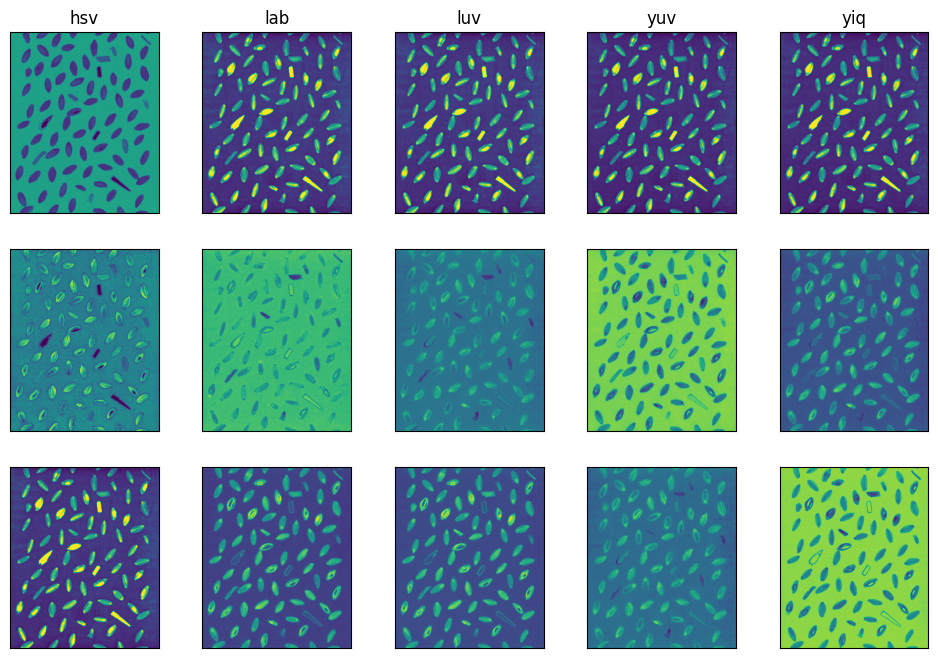

In [10]:
#reference unlabeled and labeld mixture picture

subdir=os.listdir(data_dir)

#removed subdir with mixt stuff
for sub in list(subdir):
    if 'Mixture' not in sub:
        subdir.remove(sub)

print(subdir)

Df_mix=pd.DataFrame()
count=0
fpath_unlabeled =data_dir+'/'+subdir[0]
fpath_labeled =data_dir+'/'+subdir[1]

frames=os.listdir(fpath_unlabeled)
for i in range(len(frames)):
    file_unlabeled=fpath_unlabeled+'/'+frames[i]
    file_labeled  =fpath_labeled+'/'+frames[i]
    row=pd.DataFrame(data={'unlabeled':file_unlabeled,'labeled':file_labeled},index=[i])   
    Df_mix=pd.concat([Df_mix,row])





filename=Df_mix['unlabeled'].iloc[10]
img=utils.load_img(filename)
img_array=utils.img_to_array(img)
img_array=img_array.astype('uint8')#ok then need of cv2.convertScaleAbs

#convert in hsv?
#convert in Lab?
#convert in Luv?
#input = cv2.cvtColor(input, cv2.COLOR_RGB2HSV)# hue | saturation | value
# img_array = cv2.cvtColor(img_array,cv2.COLOR_RGB2Lab)# lightness | red/green | yellow/blue 

img_hsv=cv2.cvtColor(img_array, cv2.COLOR_RGB2HSV)# hue | saturation | value
img_lab=cv2.cvtColor(img_array,cv2.COLOR_RGB2Lab)# lightness | red/green | yellow/blue 
img_luv=cv2.cvtColor(img_array,cv2.COLOR_RGB2Luv)# lightness | red/green | yellow/blue 
img_yuv=cv2.cvtColor(img_array,cv2.COLOR_RGB2YUV)# 
img_yCrCb=cv2.cvtColor(img_array,cv2.COLOR_RGB2YCrCb)# same as yuv bbut different order 

#Y=brightness=V in hsv

from skimage.color import rgb2yiq
img_yiq=rgb2yiq(img_array)

fig,ax=plt.subplots(3,5,figsize=(12,8))

for i in range(3):
    ax[i,0].imshow(img_hsv[:,:,i]) #hsv color
    ax[i,0].set_xticks([])
    ax[i,0].set_yticks([])
    if i==0:
        ax[i,0].set_title('hsv')

for i in range(3):
    ax[i,1].imshow(img_lab[:,:,i]) #lab color
    ax[i,1].set_xticks([])
    ax[i,1].set_yticks([])
    if i==0:
        ax[i,1].set_title('lab')

for i in range(3):
    ax[i,2].imshow(img_luv[:,:,i]) #luv color
    ax[i,2].set_xticks([])
    ax[i,2].set_yticks([])
    if i==0:
        ax[i,2].set_title('luv')

for i in range(3):
    ax[i,3].imshow(img_yuv[:,:,i]) #yuv color
    ax[i,3].set_xticks([])
    ax[i,3].set_yticks([])
    if i==0:
        ax[i,3].set_title('yuv')

for i in range(3):
    ax[i,4].imshow(img_yiq[:,:,i]) #yiq color
    ax[i,4].set_xticks([])
    ax[i,4].set_yticks([])
    if i==0:
        ax[i,4].set_title('yiq')
#img_array[:,:,0]

###-> hsv or yiq best? both available in tensorflow

# yuv vs yiq : https://hbfs.wordpress.com/2018/05/08/yuv-and-yiq-colorspaces-v/ . almost the same this is PAL vs SEQAL

#img_array=utils.img_to_array(img)
#tf.image.rgb_to_yuv(tf.convert_to_tensor(img_array))[:,:,2]
#v negatif, ok? yes, see https://en.wikipedia.org/wiki/Y%E2%80%B2UV

In [ ]:
#work fine but every wheat has to be differentiate before, which could be problematic for 'live' action
from tensorflow.keras.backend import clear_session
import cv2
############################## U-NET for instance detection and classification
from keras.layers import Input,Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, BatchNormalization, Activation, concatenate
from keras.layers import Lambda, LeakyReLU
import tensorflow as tf

clear_session() #clear keras session


pct_dropout=0.2


def double_conv(x,n_filter):
    ##BatchNormalization before activation so activation is more stable?  or after because batches are small?

    # 1st Conv2D then ReLU activation
    x1 = Conv2D(filters=n_filter, #dimension of output space=number of filter in the convolution
                kernel_size=3,  #convolution  window size
                kernel_initializer = 'he_normal', #normal distribution centered on 0
                padding = 'same'
                )(x)
    #x1=Activation('leaky_relu')(x1)
    #x1=Activation('relu')(x1)    
    x1=BatchNormalization(axis=-1)(x1) #before activation so activation is more stable?  or after because batches are small?
    x1=LeakyReLU(negative_slope=0.1)(x1)
    #x1=Activation('relu')(x1)  
   
    # Conv2D then ReLU activation
    x2 = Conv2D(filters=n_filter, #dimension of output space=number of filter in the convolution
                kernel_size=3,  #convolution  window size
                kernel_initializer = 'he_normal', #normal distribution centered on 0
                padding = 'same',
                )(x1)
    #x2=Activation('leaky_relu')(x2)
    #x2=Activation('relu')(x2)    
    x2=BatchNormalization(axis=-1)(x2)
    x2=LeakyReLU(negative_slope=0.1)(x2)
    #x2=Activation('relu')(x2)    
    return x2


def down(x,pct_dropout,n_filter):
    conved=double_conv(x,n_filter=n_filter)
    downed=MaxPooling2D(pool_size=(2,2),padding='valid')(x)
    downed=Dropout(pct_dropout)(downed)
    return conved, downed 


def up(x,feature_map,pct_dropout,n_filter):
    #Conv2DTranspose : going in the opposite direction of a normal convolution, 
    xT=Conv2DTranspose(filters=n_filter,
                    kernel_size=3,
                    strides=2,#  #this is 'opposite' of maxpool 2*2
                    #kernel_initializer='he_normal', not sure here
                    padding='same'
                    #activation='linear'#'relu'
                    )(x)
    
    concat_result=concatenate([xT,feature_map])#bon ordre?
    conved=double_conv(concat_result,n_filter=n_filter)
    out=Dropout(pct_dropout)(conved)
    return out 



def color_conversion(x):
    #return tf.image.rgb_to_hsv(x)#hsv
    #return tf.image.rgb_to_yuv(x)#Luv
    return tf.image.rgb_to_yiq(x) #

def make_Unet_model(img_width,img_height,nfilt):

    input=Input(shape=(img_width,img_height,3))#

    Color_change=Lambda(color_conversion)
    input2=Color_change(input)

    ####successive downscaling aka encoding
    conv_1,downed=down(input2,pct_dropout,n_filter=nfilt)
    conv_2,downed=down(downed,pct_dropout,n_filter=nfilt*2)
    conv_3,downed=down(downed,pct_dropout,n_filter=nfilt*4)
    conv_4,downed=down(downed,pct_dropout,n_filter=nfilt*8)

    #transition from  encoder to decoder, aka model bottleneck
    transition=double_conv(downed,n_filter=nfilt*16)

    #successive upscaling aka decoding
    up4=up(transition,conv_4,pct_dropout,n_filter=nfilt*8)
    up3=up(up4,conv_3,pct_dropout,n_filter=nfilt*4)
    up2=up(up3,conv_2,pct_dropout,n_filter=nfilt*2)
    up1=up(up2,conv_1,pct_dropout,n_filter=nfilt)



    result=Conv2D( filters=3+1, #0=background here!   #here filters= number of class to predict
                    kernel_size=1,#should be 1, any other number is a test,
                    padding="same",
                    activation = 'softmax'
                    )(up1)


    Unet_model = tf.keras.Model(inputs=[input],
                                outputs=[result],
                                name="U-Net")

    return Unet_model

#tf.keras.utils.plot_model(Unet_model, show_shapes=True)

Unet_model=make_Unet_model(img_width,img_height,64)
#Unet_model.summary()


####Unet conv2d output give x,y,nclass
#### -> mask need to be     x,y,nclass -> cateogrize mask according to last dimension


c:\Users\juano\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [12]:

from tensorflow.keras.ops.image import resize 
import cv2
from tensorflow.keras.utils import to_categorical


labeldic={'Foreign': 1, 'Starchy': 2, 'Vitreous': 3}



def get_img_mask(Df):

    X=np.zeros((len(Df),img_width,img_height,3),dtype = np.float64)
    Y=np.zeros((len(Df),img_width,img_height,4),dtype = np.uint8)

    for i in range(len(Df)):
        filename=Df.iloc[i]['filename']
        label=Df.iloc[i]['class']

        img=utils.load_img(filename)
        img_array=utils.img_to_array(img)
        img_array=img_array#.astype(int)



        # convert to grayscale
        #convert image to 8bits, needed to gray conversion
        img_array_8b=cv2.convertScaleAbs(img_array)
        img_gray = cv2.cvtColor(img_array_8b,cv2.COLOR_RGB2GRAY)

        # threshold
        ret,thresh = cv2.threshold(img_gray,80,255,cv2.THRESH_BINARY)

        # get contours
        result = img_array_8b.copy()
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        clean_contours=[]
        for contour in contours:
            area=cv2.contourArea(contour)
            if area> 600: #number of pixel i think
                clean_contours.append(contour)



        emptymask=np.zeros((img_gray.shape[0],img_gray.shape[1],1)) #if the extra dimension is removed, resize does not work!
        mask = cv2.drawContours(emptymask,
                                clean_contours,
                                -1,
                                color= labeldic[label],
                                thickness=cv2.FILLED)
        #mask=mask#.astype('uint8')
        #print(label, dic[label])
        
        #mask use rgb2gray but save hsv?
        #convert in hsv?
        #convert in Lab?
        #img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2HSV)# hue | saturation | value
        # img_array = cv2.cvtColor(img_xx,cv2.COLOR_RGB2Lab)# lightness | red/green | yellow/blue 

        
        ############resize 
        resized=resize(img_array,
                    size=(img_width,img_height),
                    fill_value=0,
                    data_format='channels_last',
                    interpolation='bilinear'
                    )
        img_resized=resized.numpy() # i dont want tensor


        resized=resize(mask,
                    size=(img_width,img_height),
                    fill_value=0,
                    data_format='channels_last',
                    interpolation='nearest'#'bilinear'
                    )
        mask_resized=resized.numpy() # i dont want tensor
        mask_resized=to_categorical(np.squeeze(mask_resized,axis=-1),num_classes=4)#Unet output is one layer=one class

        X[i]=img_resized /255#image rescaling to be between 0 and 1
        Y[i]=mask_resized

        #Y=to_categorical(Y[:,:,:,0],num_classes=4)#Unet output is one layerr=one class

    return X,Y


IMG,MASK=get_img_mask(Df_train)



filename    Data/Dataset2-Durum Wheat Video Images/2-Image...
class                                                 Starchy
Name: 109, dtype: object
expected categories in mask [0 2]
existing categories in mask [0 2]
expected color: orange
if bad borders in right figure, visualization errors!


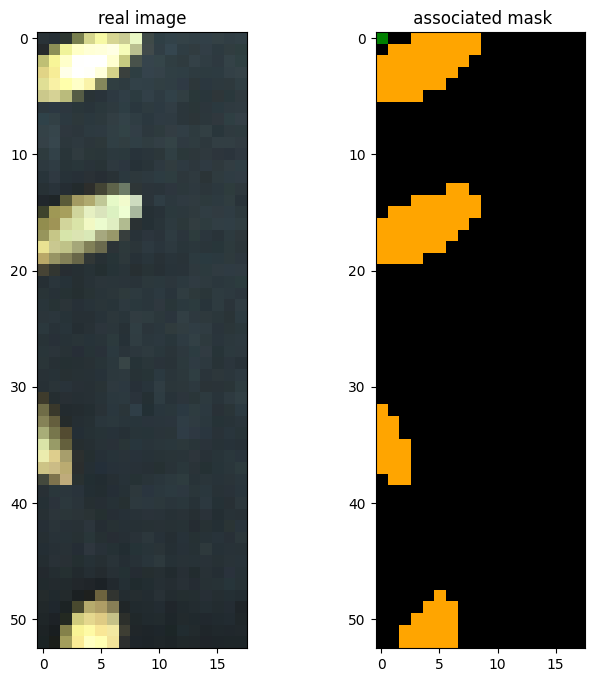

In [13]:
#############A test to verify if mask is correctly computed
import random
from matplotlib import colors

# Create the custom colormap
discrete_colors = ['black', 'red', 'orange', 'green']
mycmap = colors.ListedColormap(discrete_colors)
#layer 0: devrait etre : 1 partout sauf la ou des objet,
#layer 1: devrait etre 1 pour Foreign, 0 ailleurs,
#layer 2: devrait etre 1 pour STarchy 0 ailleurs
#layer 3: devrait etre 1 pour Vitreous 0 ailleurs


#i=10
i=random.randint(0,IMG.shape[0]-1)#try some number to check mask


# some index for visualization
idx_color=labeldic[Df_train.iloc[i]['class']]
ymin=75
ymax=ymin+120
xmin=110
xmax=xmin+120


#plt.imshow(IMG[i,ymin:ymax,xmin:xmax])


#print('mask in channel ' +str(idx_color) +' is :')
#z=MASK[i,ymin:ymax,xmin:xmax,idx_color]#.astype(int)
#print(z)
mask=np.argmax(MASK,axis=-1)#.astype(int)


#print(mask[i,ymin:ymax,xmin:xmax]) #
#print(MASK[i,ymin:ymax,xmin:xmax,3]) #

print(Df_train.iloc[i])
print('expected categories in mask [0 '+str(idx_color)+']') #0 is background
print('existing categories in mask', np.unique(mask[i]))
print('expected color:',discrete_colors [idx_color] )

mask2=mask[i,ymin:ymax,xmin:xmax]
mask2[0,0]=3# a trick to enforce mycmap color for vizualisation
fig,ax=plt.subplots(1,2,figsize=(8,8))
ax[0].imshow(IMG[i,ymin:ymax,xmin:xmax])
ax[1].imshow(mask2,cmap=mycmap)
ax[0].set_title('real image')
ax[1].set_title(' associated mask')
#np.unique(mask[i,ymin:ymax,xmin:xmax])


print('if bad borders in right figure, visualization errors!')

In [14]:
Df_train

,filename,class
20,Data/Dataset2-Durum Wheat Video Images/1-Image...,Vitreous
81,Data/Dataset2-Durum Wheat Video Images/2-Image...,Starchy
54,Data/Dataset2-Durum Wheat Video Images/1-Image...,Vitreous
28,Data/Dataset2-Durum Wheat Video Images/1-Image...,Vitreous
168,Data/Dataset2-Durum Wheat Video Images/3-Image...,Foreign
...,...,...
89,Data/Dataset2-Durum Wheat Video Images/2-Image...,Starchy
147,Data/Dataset2-Durum Wheat Video Images/3-Image...,Foreign
138,Data/Dataset2-Durum Wheat Video Images/3-Image...,Foreign
177,Data/Dataset2-Durum Wheat Video Images/3-Image...,Foreign


In [ ]:
from keras.metrics import IoU, MeanIoU # IoU should increase will training
import keras
from tensorflow.keras.backend import clear_session
from tensorflow.keras import backend as K

####try already done network
# import os
# os.environ["SM_FRAMEWORK"] = "tf.keras"
# import segmentation_models as sm
# BACKBONE = 'resnet34'
# Unet_model=sm.Unet(BACKBONE, encoder_weights='imagenet')



clear_session()

Batch_size=12*2

data_train=get_img_mask(Df_train)
data_eval=get_img_mask(Df_eval)




#https://github.com/qubvel/segmentation_models?tab=readme-ov-file#examples
#BACKBONE = 'resnet34'
#Unet_model=sm.Unet(BACKBONE, encoder_weights='imagenet',classes=4,activation='softmax')
#failed

##explanation for image metrics
###https://medium.com/mastering-data-science/understanding-evaluation-metrics-in-medical-image-segmentation-d289a373a3f
wei={0:10.0,1:3.0,2:3.0,3:3.0}

def weightedLoss(originalLossFunc, weightsList):
    '''not my function! found it on the web'''
    
    def lossFunc(true, pred):
        #argmax returns the index of the element with the greatest value
        #done in the class axis, it returns the class index    
        classSelectors = keras.ops.argmax(true, axis=-1) 
            #if your loss is sparse, use only true as classSelectors

        #considering weights are ordered by class, for each class
        #true(1) if the class index is equal to the weight index   
        classSelectors = [keras.ops.equal(i, classSelectors) for i in range(len(weightsList))]

        #casting boolean to float for calculations  
        #each tensor in the list contains 1 where ground true class is equal to its index 
        #if you sum all these, you will get a tensor full of ones. 
        classSelectors = [keras.ops.cast(x, tf.keras.backend.floatx()) for x in classSelectors]

        #for each of the selections above, multiply their respective weight
        weights = [sel * w for sel,w in zip(classSelectors, weightsList)] 

        #sums all the selections
        #result is a tensor with the respective weight for each element in predictions
        weightMultiplier = weights[0]
        for i in range(1, len(weights)):
            weightMultiplier = weightMultiplier + weights[i]


        #make sure your originalLossFunc only collapses the class axis
        #you need the other axes intact to multiply the weights tensor
        loss = originalLossFunc(true,pred) 
        loss = loss * weightMultiplier

        return loss
    return lossFunc


def dice_loss_multiclass(y_true,y_pred):
    '''
    Dice coefficient for multiple class.
    Ignores background pixel label 0!!!!!!
    Pass to model as loss during compile statement
    see https://veradp-ai.com/iou-vs-dice/
    '''
    smooth=1e-4

    dice=0
    for i in range(1,len(labeldic)+1):
        y1=y_true[...,i]
        y2=y_pred[...,i]
        intersection= K.sum(y1*y2,axis=[1,2])
        union=K.sum(y1+y2,axis=[1,2])
        dic=2*(intersection+smooth)/(union+smooth)
        dice+=dic

    dice_loss=1-dice
    return dice_loss




Unet_model=make_Unet_model(img_width,img_height,64)

opt = Adam(learning_rate=0.0005*2)
Unet_model.compile( optimizer=opt,
                    #loss=keras.losses.categorical_crossentropy, # a probabilty loss (entropy=chaos)
                    #loss=keras.losses.dice, #see or highly unbalanced segmentations https://arxiv.org/abs/1707.03237
                    #loss=keras.losses.tversky, # 3D fully convolutional network see https://arxiv.org/abs/1706.05721
                    #loss=keras.losses.categorical_focal_crossentropy,#see https://arxiv.org/pdf/1708.02002
                    #loss=[keras.losses.categorical_crossentropy, keras.losses.dice],
                    #loss=weightedLoss(keras.losses.dice,wei),#!
                    loss=dice_loss_multiclass, 
                    metrics=['accuracy',
                             IoU(num_classes=4,target_class_ids=[2]), # for a given class
                             MeanIoU(num_classes=4)]# all class combined
                    )
           



c:\Users\juano\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 915ms/stepWARNING:tensorflow:6 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001FB12DCE520> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 435ms/step


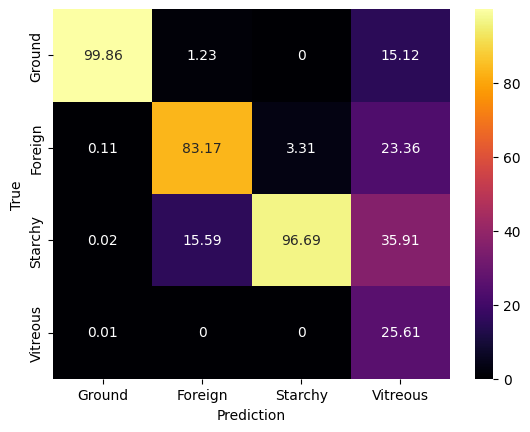

accuracy=89.62
              precision    recall  f1-score   support

      Ground       1.00      0.98      0.99    402275
     Foreign       0.83      0.13      0.22     17222
     Starchy       0.97      0.01      0.01     23147
    Vitreous       0.26      1.00      0.41     16108

    accuracy                           0.90    458752
   macro avg       0.76      0.53      0.41    458752
weighted avg       0.96      0.90      0.89    458752


 
 



(28, 128, 128, 4)

In [89]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns


def show_confusion(y_test,y_predic,classes,titl):
    '''
    Show confusion matrix and classification error for a given prediction (= classification here)
    '''

    cm = confusion_matrix(y_test, y_predic)
    cm=cm / cm.sum(axis=0)*100#normalisation to get proba
    cm=cm.astype('float')
    cm2=np.array(["%.2f" % w for w in cm.reshape(cm.size)])
    cm2=cm2.reshape(cm.shape).astype(float)       

    ax=sns.heatmap(cm2,annot=True,cmap='inferno',fmt='g',xticklabels=classes,yticklabels=classes)
    ax.set(xlabel='Prediction',ylabel='True')
    ax.set(title=titl)

    acc='{:.2f}'.format(accuracy_score(y_test,y_predic)*100 )  
    report=classification_report(y_test, y_predic,target_names=classes,output_dict=False)

    plt.show()
    print('accuracy='+acc)
    print(report)
    print('\n \n \n')



im,mask=get_img_mask(Df_test)
mask=np.argmax(mask,axis=-1)

#make prediction on unseen images
proba=Unet_model.predict(im,batch_size=Batch_size)
prediction=np.argmax(proba,axis=-1)

show_confusion(mask.flatten(),
               prediction.flatten(),
               classes=['Ground','Foreign','Starchy','Vitreous'],
               titl=''
               )


#% NOT OK???, sum is not 100, neither rows or columns!!!
proba.shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


filename    Data/Dataset2-Durum Wheat Video Images/3-Image...
class                                                 Foreign
Name: 133, dtype: object
expected color: red
expected values: (array([0, 1], dtype=int64), array([14651,  1733], dtype=int64))
predicted values: (array([0, 1, 2, 3], dtype=int64), array([14490,   188,     1,  1705], dtype=int64))


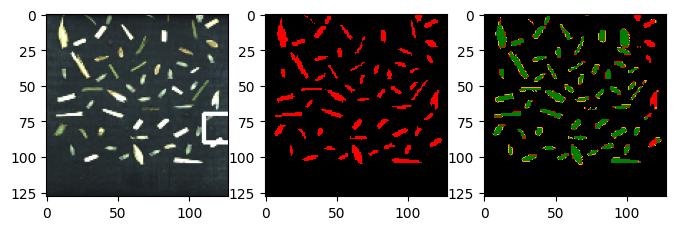

In [91]:
ymin=70
ymax=ymin+20
xmin=110
xmax=xmin+20

#foreign=red
#starchy=orange
#vitreous=green

i=random.randint(0,im.shape[0]-1)#try some number

myimg=im[i].copy()#cv2.convertScaleAbs(mask[i])
cv2.rectangle(myimg,(xmin,ymin),(xmax,ymax),(120,120,120),2)

print(Df_test.iloc[i])
idx_color=labeldic[Df_test.iloc[i]['class']]
print('expected color:',discrete_colors [idx_color] )


mask[i,0,0]=3# a trick to enforce mycmap color for vizualisation
prediction[i,0,0]=3# a trick to enforce mycmap color for vizualisation
fig,ax=plt.subplots(1,3,figsize=(8,16))
ax[0].imshow(myimg)
ax[1].imshow(mask[i],cmap=mycmap)
ax[2].imshow(prediction[i],cmap=mycmap)
#fig.colorbar(p,ax=ax[1],orientation='horizontal')

mask[i,0,0]=0
prediction[i,0,0]=0
print('expected values:',np.unique(mask[i],return_counts=True))
print('predicted values:',np.unique(prediction[i],return_counts=True))

In [92]:
print('mask \n',mask[i,ymin:ymax,xmin:xmax])
print('\n')
print('prediction \n',prediction[i,ymin:ymax,xmin:xmax])


mask 
 [[0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0]]


prediction 
 [[0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 3 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 3 3 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 495ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'predicted')

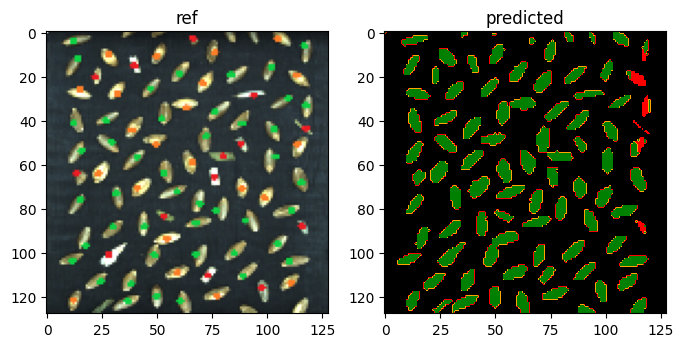

In [95]:

#### Test for images with mulitples class, reference is annotated by researcher


def get_image(Df,columnfile):

    IM=np.zeros((len(Df),img_width,img_height,3),dtype = np.float64)

    for i in range(len(Df)):
        filename=Df[columnfile].iloc[i]

        img=utils.load_img(filename)
        img_array=utils.img_to_array(img)
        img_array=np.float32(img_array.astype(int))
        #print(img_array.shape)

        ##if model trained for hsv or lab colors
        #convert in hsv?
        #convert in Lab?
        #img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2HSV)# hue | saturation | value
        # img_array = cv2.cvtColor(img_array,cv2.COLOR_RGB2Lab)# lightness | red/green | yellow/blue 

        resized=resize(img_array,
                    size=(img_width,img_height),
                    fill_value=0,
                    data_format='channels_last',
                    interpolation='bilinear'
                    )
        img_resized=resized.numpy() # i dont want tensor


        IM[i]=img_resized/255

    return IM


IM_mixed_unlabeled=get_image(Df_mix,'unlabeled')
IM_mixed_labeled=get_image(Df_mix,columnfile='labeled')


proba=Unet_model.predict(IM_mixed_unlabeled,batch_size=Batch_size)
Prediction=np.argmax(proba,axis=-1)

i=random.randint(0,IM_mixed_labeled.shape[0]-1)#try some number to check mask


IM_mixed_labeled[i,0,0]=3# a trick to enforce mycmap color for vizualisation
Prediction[i,0,0]=3# a trick to enforce mycmap color for vizualisation
fig,ax=plt.subplots(1,2,figsize=(8,16))
ax[0].imshow(IM_mixed_labeled[i])
ax[1].imshow(Prediction[i],cmap=mycmap)
ax[0].set_title('ref')
ax[1].set_title('predicted')

#foreign=red
#starchy=orange
#vitreous=green

#proba

[[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0]]


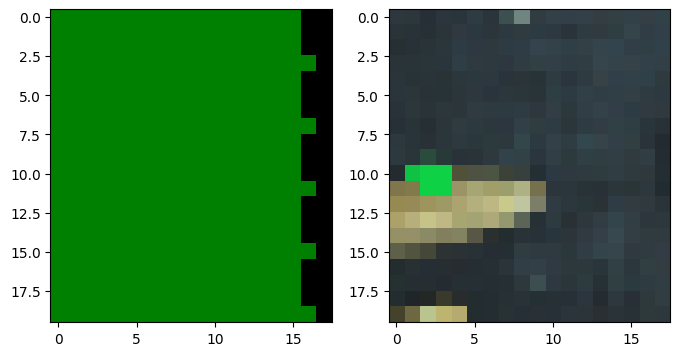

In [21]:
fig,ax=plt.subplots(1,2,figsize=(8,16))
ax[0].imshow(Prediction[i,ymin:ymax,xmin:xmax],cmap=mycmap)
ax[1].imshow(IM_mixed_labeled[i,ymin:ymax,xmin:xmax])

print(Prediction[i,ymin:ymax,xmin:xmax])

In [22]:
################################################################################################################
######################################### MAYBE NOT ENOUGH DATA???  generate image##############################
stop

from keras_preprocessing.image import ImageDataGenerator

# datagen=ImageDataGenerator(rescale=1/255)
# train_datagen=datagen.flow_from_dataframe(dataframe=Df_train,
#                                           target_size=(img_width,img_height),
#                                           class_mode='sparse', 
#                                           shuffle=True, # so order in filename is not important
#                                           batch_size=12,
#                                           rotation_range=10,
#                                           )

def make_datagen(Df):

    IMG,MASK=get_img_mask(Df)

    img_datagen=ImageDataGenerator(rotation_range=20) # rescale not neeed as already done im get_img_mask
    mask_datagen=ImageDataGenerator(rotation_range=20) #rescale not needed as mask is categorical
    seed=42

    img_datagen.fit(IMG,seed=seed,augment=True)
    mask_datagen.fit(MASK,seed=seed,augment=True)

    x=img_datagen.flow(IMG,batch_size=Batch_size,seed=seed)
    y=mask_datagen.flow(MASK,batch_size=Batch_size,seed=seed)

    return zip(x, y)


train_datagen=make_datagen(Df_train)
eval_datagen=make_datagen(Df_eval)


A,b=next(train_datagen)

fig,ax=plt.subplots(1,2)
ax[0].imshow(A[0])
ax[1].imshow(np.argmax(b[0],-1))



NameError: name 'stop' is not defined

In [ ]:
clear_session()

Unet_model=make_Unet_model(img_width,img_height,64)

opt = Adam(learning_rate=0.0005)
Unet_model.compile( optimizer=opt,
                    loss=keras.losses.categorical_crossentropy, # a probabilty loss (entropy=chaos)
                    #loss=keras.losses.dice, #see https://arxiv.org/abs/1707.03237
                    #loss=keras.losses.tversky, #seee https://arxiv.org/abs/1706.05721
                    #loss=keras.losses.categorical_focal_crossentropy,#see https://arxiv.org/pdf/1708.02002
                    #loss=weightedLoss(keras.losses.categorical_crossentropy,wei),
                    metrics=['accuracy',
                             IoU(num_classes=4,target_class_ids=[1]), # for a given class
                             MeanIoU(num_classes=4)]# all class combined
                    )
           
history = Unet_model.fit(*train_datagen,
                    validation_data=eval_datagen,
                    epochs=10
                    ) 



In [ ]:

im,mask=get_img_mask(Df_test)
mask=np.argmax(mask,axis=-1)

#make prediction on unseen images
proba=Unet_model.predict(im,batch_size=Batch_size)
prediction=np.argmax(proba,axis=-1)

show_confusion(mask.flatten(),
               prediction.flatten(),
               classes=['Ground','Foreign','Starchy','Vitreous'],
               titl=''
               )


In [ ]:

IMG,MASK=get_img_mask(Df_test)


batch=IMG
y_proba=Unet_model.predict(batch)
y_pred=np.argmax(y_proba,axis=-1) 




fig,ax=plt.subplots(1,2,figsize=(8,16))

i=2
ax[0].imshow(batch[i])
ax[1].imshow(y_pred[i])